In this notebook, we try to reproduce the results of <i>Figure 3<i> of <i>Yuan, Cao, Zhao & Wu. (2017). Higher-dimension Tensor Completion via Low-rank Tensor Ring Decomposition.</i>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from Models.TR_WOPT import TR_WOPT_Model
from metrics import RSE
from Utils import mask_img, TR_fold, TR_unfold

img shape:  (256, 256, 3)


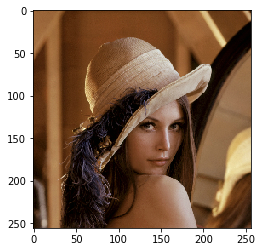

In [3]:
# Read lena image

img = cv2.imread('../data/lena.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
print("img shape: ", img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


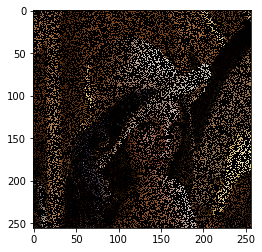

In [4]:
# Mask image

missing_rate=0.7
img_missing = mask_img(img, missing_rate=missing_rate)
plt.imshow(img_missing.astype(int))

In [15]:
# Reshape the image in 5D and 9D

img_17D = img_missing.reshape([2]*16 + [3])
img_9D = np.moveaxis(img_17D, [0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15, 16], range(17))\
    .reshape([4]*8 + [3])
img_5D = np.moveaxis(img_missing.reshape([4]*8 + [3]), [0, 4, 1, 5, 2, 6, 3, 7, 8], range(9))\
    .reshape([16]*4 + [3])

In [27]:
# Create and train using gradient descent
model = TR_WOPT_Model(img_missing, (12, 12, 12, 12), optimization="ncg")
model.train(5000)
print("normalized loss: ", model.train_logs)

         Current function value: 13180.391218
         Iterations: 4000
         Function evaluations: 6335
         Gradient evaluations: 6335
normalized loss:  0.22346084835028787


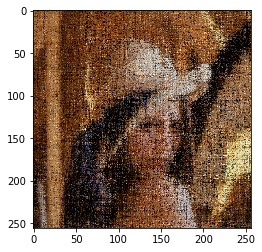

In [28]:
# Reconstruct the image using the trained model

prediction = model.predict()
prediction = np.clip(prediction, 0, 255)
plt.imshow(prediction.astype(int))

In [29]:
# Compute the RSE of our prediction

error = RSE(img, prediction)
print("RSE:", error)

RSE: 3.7043756037525815


In [22]:
# Train each models and compute their prediction

ranks = [12, 24, 36, 48]
imgs = [img_missing, img_5D, img_9D]
dims = [3, 5, 9]

predictions = {}

for img, n_dims in zip(imgs, dims):
    for rank in ranks:
        tr_ranks = [rank]*(n_dims + 1)
        
        model = TR_WOPT_Model(img, tr_ranks, optimization="ncg")
        model.train(1000)
        
        prediction = model.predict()
        prediction = np.clip(prediction, 0, 255)
        
        predictions[f"n_dims_{n_dims}_rank_{rank}"] = prediction

58983

In [ ]:
# Compute the RSE for each predictions

for img, n_dims in zip(imgs, dims):
    for rank in ranks:
        